# Fibre Throughput: estimation, smoothing, saving, and application

This tutorial walks you through computing a **fibre-throughput correction** from twilight/flat RSS files, visualising it, **smoothing** it (polynomial or spline), saving to FITS, and **applying** it to science data.

**What you'll learn**
1. Load KOALA RSS files (twilight/flat frames)
2. Build a throughput correction via `ThroughputCorrection.from_rss`
3. Inspect throughput quality
4. Smooth the 2D throughput along wavelength using **polynomials** or **splines**
5. Save throughput to FITS and reload it
6. Apply the correction to an RSS and verify the effect
7. Tips for parameter tuning and troubleshooting


## 0. Environment

This notebook assumes `pykoala` is installed and data are laid out under `../data/koala/<grating>/` as in the examples below.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pykoala.instruments.koala_ifu import koala_rss
from pykoala.rss import combine_rss
from pykoala.plotting.utils import plot_fibres
from pykoala.corrections.throughput import ThroughputCorrection, Throughput

plt.rcParams["figure.dpi"] = 120

## 1. Data selection

Choose the AAOmega grating:

- `580V`: ~3700–6000 Å (blue arm)
- `385R`: ~6000–9000 Å (red arm)

We will use short twilight frames with names like `27feb2000XXred.fits` under `../data/koala/<grating>/`.

In [2]:
# Select the AAOMEGA grating (580V -> blue arm, 385R -> red arm)
aaomega_gratings = {'580V': 1, '385R': 2}
grating = '385R'  # change to '580V' if needed
grating = '580V'  # change to '580V' if needed

# Example file indices for twilight frames
twilight_indices = [9, 10, 11, 12]

data_dir = os.path.join("..", "data", "koala", grating)
print("Using data directory:", data_dir)

Using data directory: ../data/koala/580V


## 2. Load twilight frames (RSS)

We load a small set of twilight exposures to estimate the relative fibre efficiencies. If your file layout differs, adapt the path pattern below.

In [3]:
rss_list = []
missing = []
for i in twilight_indices:
    fname = f"27feb{aaomega_gratings[grating]}00{i:02d}red.fits"
    path = os.path.join(data_dir, fname)
    if os.path.isfile(path):
        rss_list.append(koala_rss(path))
    else:
        missing.append(path)

if missing:
    print("Missing files:")
    for m in missing:
        print(" -", m)
if not rss_list:
    raise FileNotFoundError("No input RSS files were found. Please check paths.")

print(f"Loaded {len(rss_list)} RSS frames.")

[pykoala] 2025/09/16 09:47|INFO> 
> Reading KOALA RSS file 27feb10009red.fits
[pykoala] 2025/09/16 09:47|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/09/16 09:47|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2025/09/16 09:47|INFO> 
> Reading KOALA RSS file 27feb10010red.fits
[pykoala] 2025/09/16 09:47|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/09/16 09:47|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2025/09/16 09:47|INFO> 
> Reading KOALA RSS file 27feb10011red.fits
[pykoala] 2025/09/16 09:47|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/09/16 09:47|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2025/09/16 09:47|INFO> 
> Reading KOALA RSS file 27feb10012red.fit

  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]


### Quick-look at an RSS

Use the helper to inspect the 2D RSS image (fibres × wavelength).

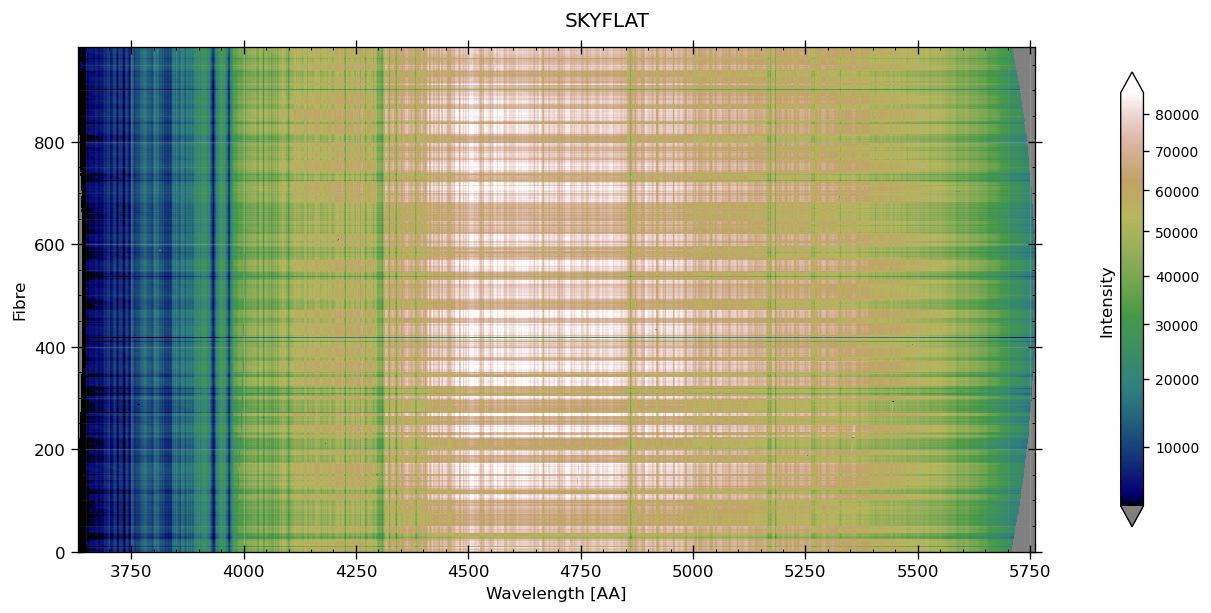

In [4]:
_ = rss_list[0].plot_rss_image()

## 3. Estimate the throughput

We combine the twilight frames, normalise by the median spectrum, and (optionally) apply a small median filter to suppress pixel-scale noise. Outliers per fibre are clipped using percentiles.

/home/pcorchoc/Develop/pykoala/src/pykoala/corrections/throughput.py:423: RuntimeWarning: All-NaN slice encountered
  combined_flux = stat_func(fluxes, axis=0)
/home/pcorchoc/anaconda3/lib/python3.13/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pcorchoc/anaconda3/lib/python3.13/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Applying median filter (size=5 px)


/home/pcorchoc/anaconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/pcorchoc/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


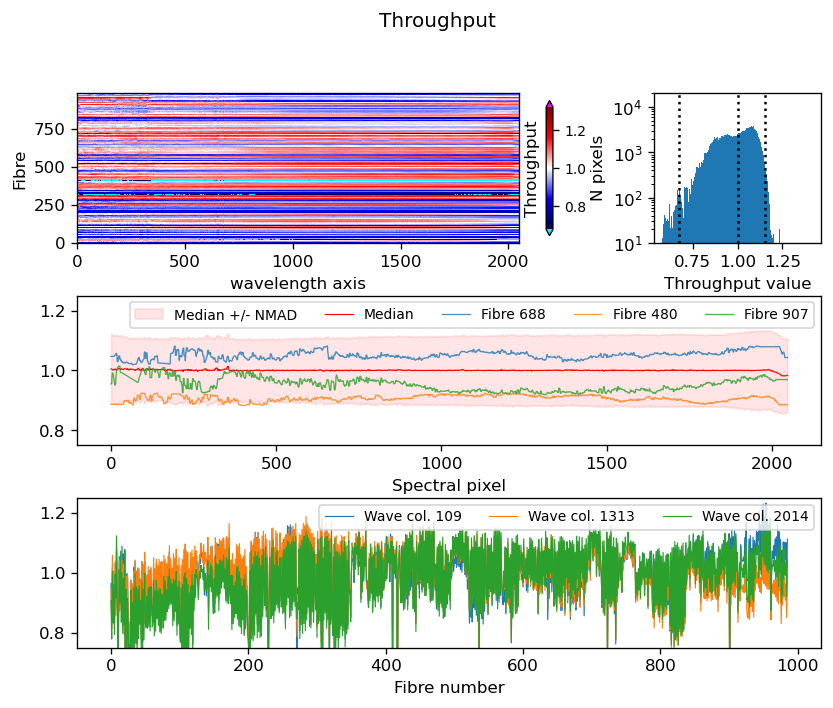

In [5]:
throughput_correction = ThroughputCorrection.from_rss(
    rss_list,
    statistic='median',   # or 'mean'
    medfilt=5,           # None to disable; typical 3–7
    pct_outliers=[5, 95],
    # Smoothing options can also be set here (see Section 4)
)

thr = throughput_correction.throughput
fig = thr.plot()

## 4. Smoothing the throughput (polynomial or spline)

Fine-scale wiggles are often not physically meaningful and may harm stability. You can smooth **per fibre** along the **wavelength axis**:

- **Polynomial:** `method="polynomial"`, `polydeg=3` (increase degree for more flexibility)
- **Spline:** `method="spline"`, `spline_s=None` lets SciPy pick a smoothing factor; set a larger `s` for stronger smoothing.

Errors can be **recomputed from residuals** (`update_error='residual'`) or **kept** (`update_error='keep'`).

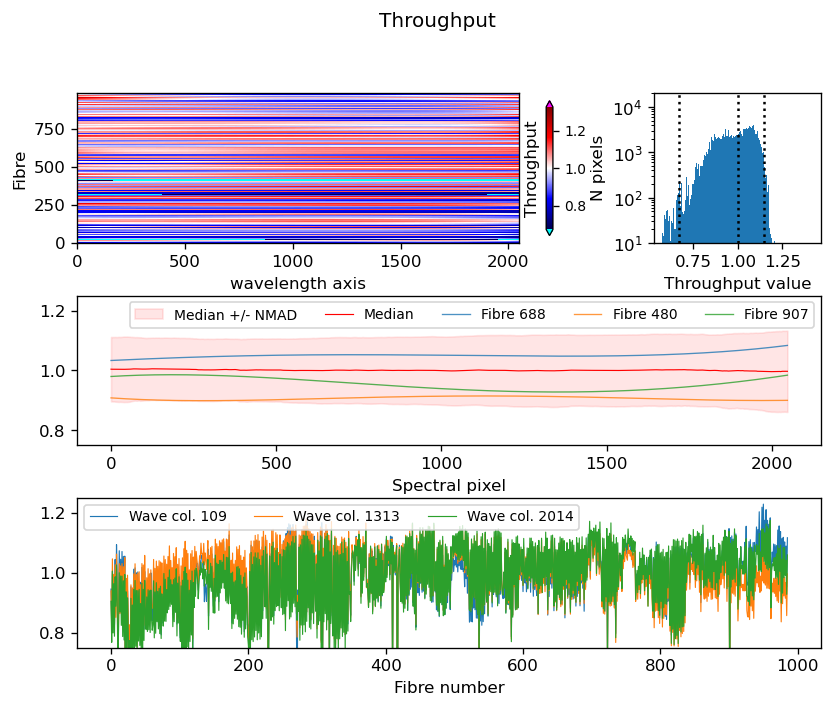

In [6]:
# Make a copy before smoothing if you want to compare
thr_poly = Throughput(
    throughput_data=np.array(thr.throughput_data, copy=True),
    throughput_error=np.array(thr.throughput_error, copy=True)
)
thr_poly.smooth(method="polynomial", axis=1, polydeg=4, update_error="residual")
fig = thr_poly.plot()

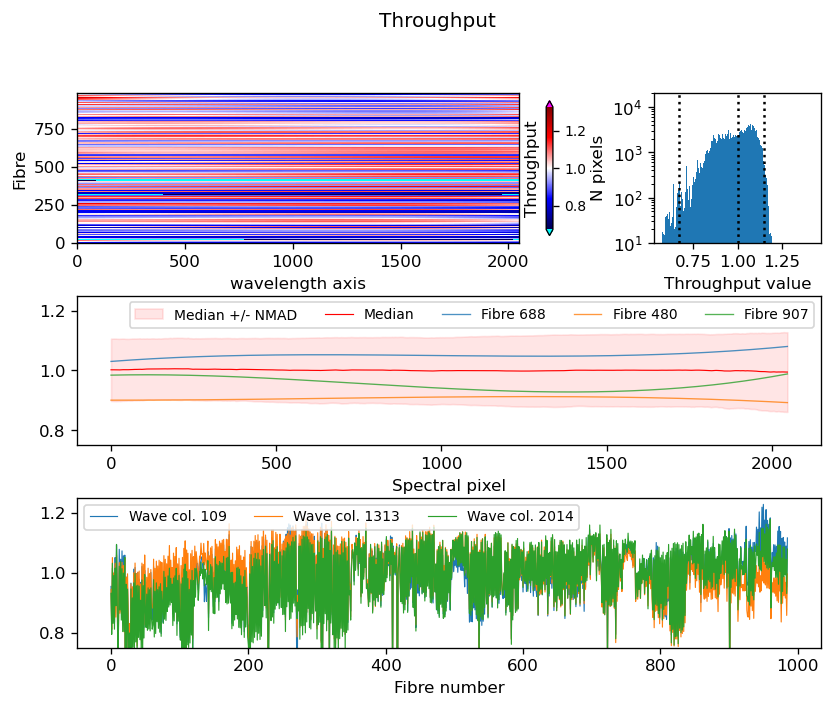

In [7]:
thr_spline = Throughput(
    throughput_data=np.array(thr.throughput_data, copy=True),
    throughput_error=np.array(thr.throughput_error, copy=True)
)
thr_spline.smooth(method="spline", axis=1, spline_s=None, update_error="residual")
fig = thr_spline.plot()

### Parameter sweep (optional)

Below we explore a small grid of smoothing parameters and plot the **median** and **NMAD** across wavelength for each choice. Use this to pick a reasonable smoothing strength.

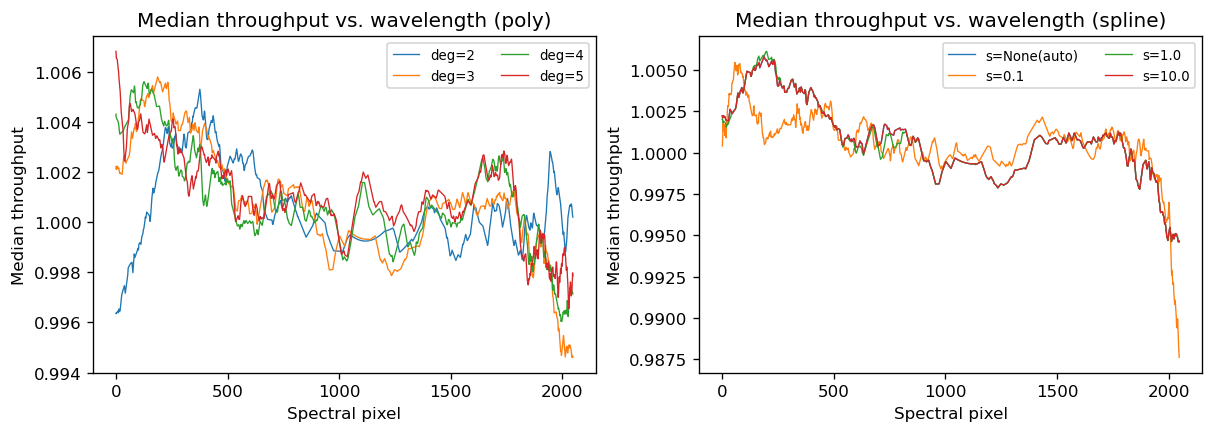

In [8]:
def statistics(arr, axis=0):
    med = np.nanmedian(arr, axis=axis)
    nmad = 1.4826 * np.nanmedian(np.abs(arr - np.nanmedian(arr, axis=axis)), axis=axis)
    return med, nmad

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), constrained_layout=True)

# Sweep polynomial degrees
degrees = [2, 3, 4, 5]
for d in degrees:
    tmp = Throughput(np.array(thr.throughput_data, copy=True), np.array(thr.throughput_error, copy=True))
    tmp.smooth(method="polynomial", axis=1, polydeg=d, update_error="keep")
    med, sc = statistics(tmp.throughput_data, axis=0)
    ax[0].plot(med, lw=0.8, label=f"deg={d}")
ax[0].set_title("Median throughput vs. wavelength (poly)")
ax[0].set_xlabel("Spectral pixel")
ax[0].set_ylabel("Median throughput")
ax[0].legend(ncol=2, fontsize=8)

# Sweep spline s values (None lets SciPy decide)
s_values = [None, 1e-1, 1.0, 10.0]
for s in s_values:
    tmp = Throughput(np.array(thr.throughput_data, copy=True), np.array(thr.throughput_error, copy=True))
    tmp.smooth(method="spline", axis=1, spline_s=s, update_error="keep")
    med, sc = statistics(tmp.throughput_data, axis=0)
    lbl = f"s={s}" if s is not None else "s=None(auto)"
    ax[1].plot(med, lw=0.8, label=lbl)
ax[1].set_title("Median throughput vs. wavelength (spline)")
ax[1].set_xlabel("Spectral pixel")
ax[1].set_ylabel("Median throughput")
ax[1].legend(ncol=2, fontsize=8)

## 5. Save and reload throughput

You can persist smoothed (or raw) throughput to FITS and reload it later.

[pykoala] 2025/09/16 09:48|INFO> Throughput saved at ../data/koala/580V/throughput_spline.fits
Saved: ../data/koala/580V/throughput_spline.fits
[pykoala] 2025/09/16 09:48|INFO> Loading throughput from ../data/koala/580V/throughput_spline.fits


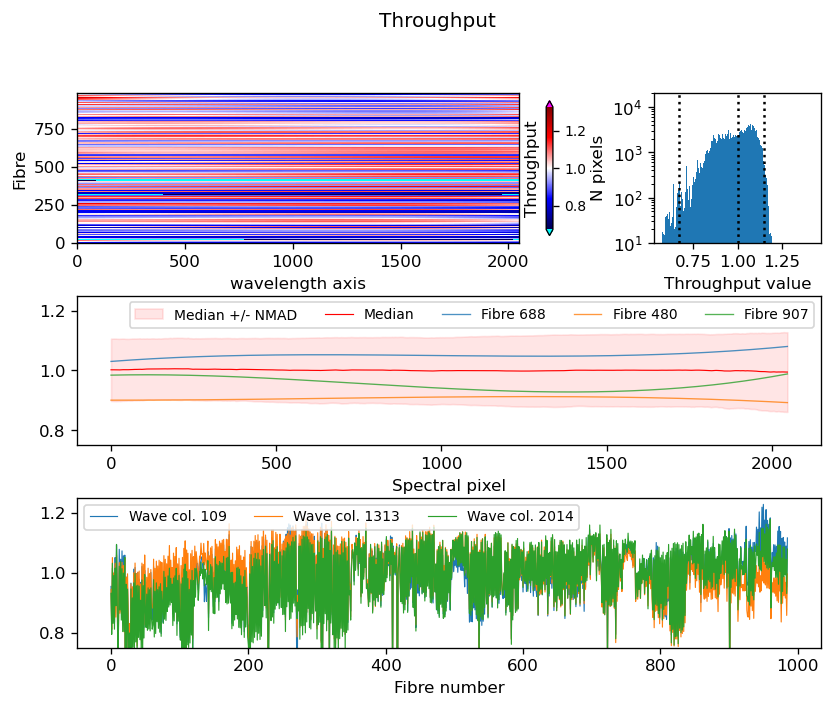

In [9]:
out_fits = os.path.join(data_dir, "throughput_spline.fits")
thr_spline.to_fits(out_fits)
print("Saved:", out_fits)

# Reload and plot
thr_reloaded = Throughput.from_fits(out_fits)
_ = thr_reloaded.plot()

## 6. Apply throughput correction to an RSS

To apply, create a `ThroughputCorrection` from a `Throughput` (or from file), and use `.apply(rss)` to get a corrected copy. Here we demonstrate using one of the twilight frames as a proxy for science data.

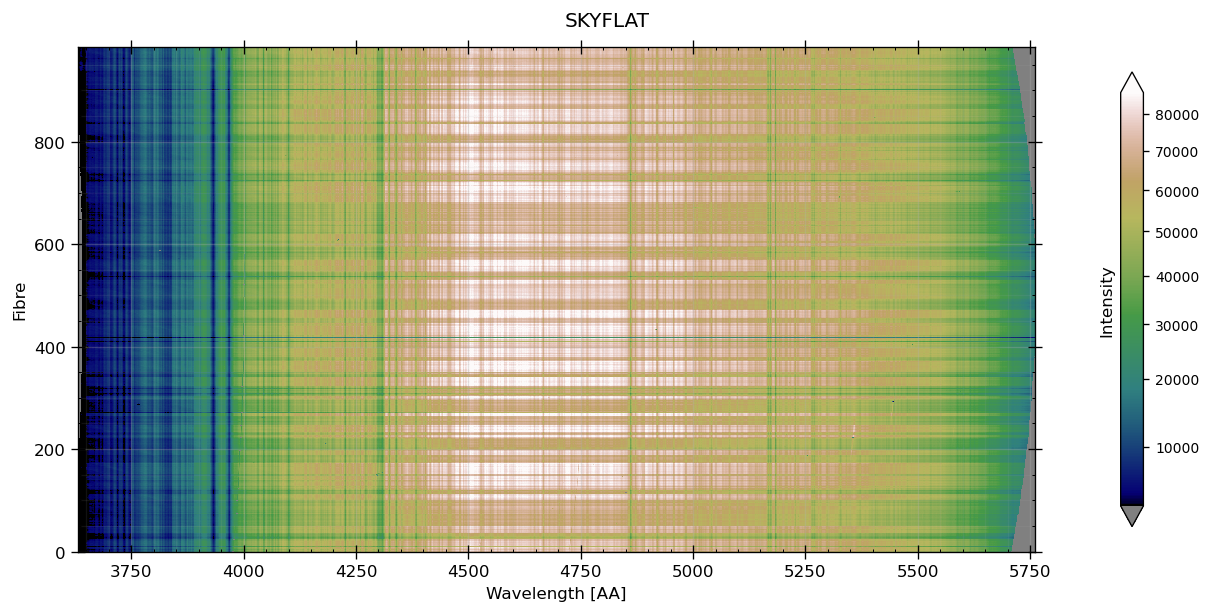

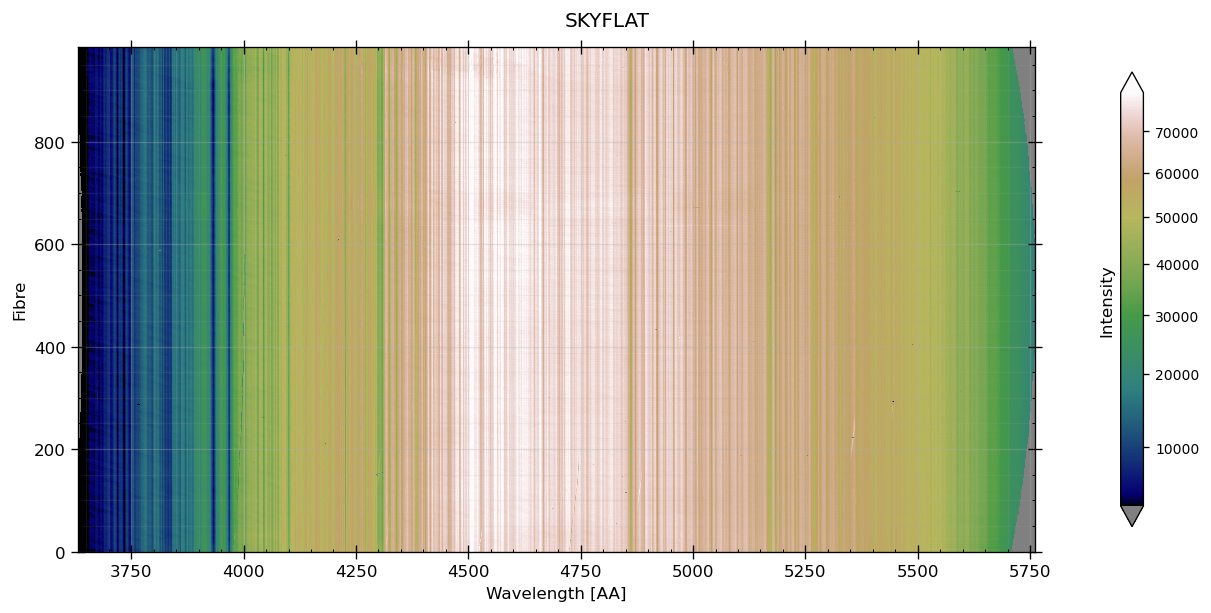

Text(0.5, 0, 'Spectral pixel')

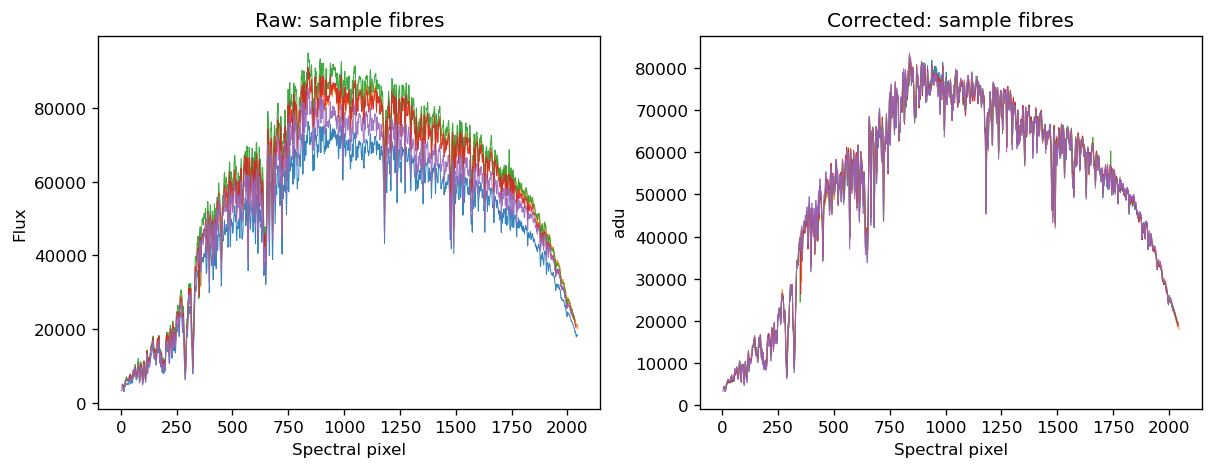

In [10]:
# Build a correction object from the smoothed throughput
tcor_spline = ThroughputCorrection(throughput=thr_spline)

# Choose an RSS to correct (use a science frame in real workflows)
rss_raw = rss_list[0]
rss_corr = tcor_spline.apply(rss_raw)

# RSS images before/after correction
fig_raw = rss_raw.plot_rss_image()
plt.show()
fig_corr = rss_corr.plot_rss_image()
plt.show()

# Individual fibres before/after
rng = np.random.default_rng(0)
idx = rng.choice(rss_raw.intensity.shape[0], size=5, replace=False)
fig, ax = plt.subplots(1, 2, figsize=(10, 3.8), constrained_layout=True)
for i in idx:
    ax[0].plot(rss_raw.intensity[i], lw=0.6, alpha=0.9)
ax[0].set_title("Raw: sample fibres")
ax[0].set_xlabel("Spectral pixel")
ax[0].set_ylabel("Flux")
for i in idx:
    ax[1].plot(rss_corr.intensity[i], lw=0.6, alpha=0.9)
ax[1].set_title("Corrected: sample fibres")
ax[1].set_xlabel("Spectral pixel")

## 7. Doing it all in one shot

You can also request smoothing **inside** `from_rss` so the returned `ThroughputCorrection` is already smoothed:

/home/pcorchoc/Develop/pykoala/src/pykoala/corrections/throughput.py:423: RuntimeWarning: All-NaN slice encountered
  combined_flux = stat_func(fluxes, axis=0)
/home/pcorchoc/anaconda3/lib/python3.13/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pcorchoc/anaconda3/lib/python3.13/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Applying median filter (size=5 px)


/home/pcorchoc/anaconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/pcorchoc/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


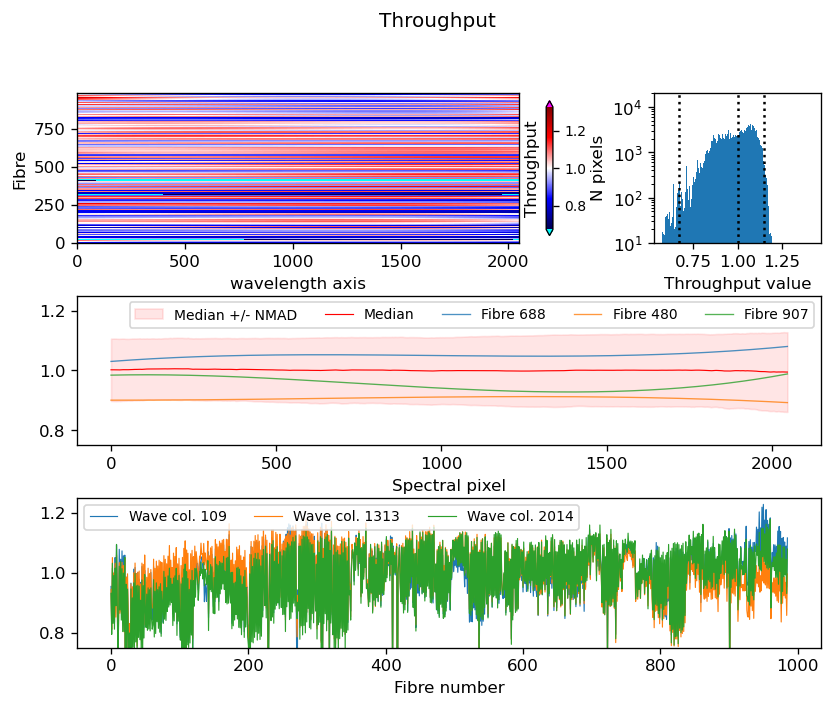

In [11]:
throughput_correction_spline = ThroughputCorrection.from_rss(
    rss_list,
    statistic='median',
    medfilt=5,
    pct_outliers=[5, 95],
    smooth_method='spline',
    smooth_axis=1,
    smooth_spline_s=None,        # auto smoothing
    smooth_update_error='residual',
    smooth_robust=True,
)
_ = throughput_correction_spline.throughput.plot()

## 8. Tips & troubleshooting

- **Axis choice:** Smoothing along wavelength (`axis=1`) is usually safest; spatial structure across fibres can be real and sharp.
- **Median filter vs. smoothing:** The median filter (`medfilt`) is a quick denoiser. Polynomial/spline smoothing models the curve and is better for broad trends.
- **Clipping:** The percentile clipping removes gross outliers per fibre. You can tighten/loosen `pct_outliers`.
- **Errors:** `update_error='residual'` replaces errors by robust residual scatter (NMAD). Use `'keep'` if you prefer the propagated errors from stacking.
- **NaNs:** If you see gaps (e.g. caused by cosmic rays), ensure `clear_nan=True` in `from_rss` (default) to interpolate per fibre before smoothing.
- **Diagnostics:** Plot a few random fibres and the median spectrum before/after correction to sanity-check.
- **Saving:** Always save the final, **smoothed** throughput you intend to apply in your science reduction, so results are reproducible.